In this assignment, we will be working with the [NOAA](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-monthly-version-4) climate data set to create some interesting visualizations.

## $\S 1.$ Database
There are three tables that we need to create within a database which are *stations*, *countries*, and *temperatures*. In order to generate a database, we need the help from ``sqlite3`` which is a module that allows us to conveniently create and query databases.

In [1]:
import sqlite3

# make a connection
conn = sqlite3.connect("noaa.db")

First, let's access the stations data set with ``pandas``.

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/noaa-ghcn/station-metadata.csv"
stations = pd.read_csv(url)
stations.head()

,ID,LATITUDE,LONGITUDE,STNELEV,NAME
0,ACW00011604,57.7667,11.8667,18.0,SAVE
1,AE000041196,25.3330,55.5170,34.0,SHARJAH_INTER_AIRP
2,AEM00041184,25.6170,55.9330,31.0,RAS_AL_KHAIMAH_INTE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI_INTL
4,AEM00041216,24.4300,54.4700,3.0,ABU_DHABI_BATEEN_AIR


Now, we can add this table to our database through the connection ``conn`` that we defined earlier.

In [3]:
stations.to_sql("stations", conn, if_exists = "replace", index = False)

We proceed similarly with the country data set.

In [4]:
url = "https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv"
countries = pd.read_csv(url)
# change the column "Name" for easier reference later on
countries = countries.rename(columns = {"Name": "Country"})
countries.head()

,FIPS 10-4,ISO 3166,Country
0,AF,AF,Afghanistan
1,AX,-,Akrotiri
2,AL,AL,Albania
3,AG,DZ,Algeria
4,AQ,AS,American Samoa


To avoid potential issues with the spacing in the column names, let's rename them in a more friendly and convenient format to work with.

In [5]:
# we don't need ISO column, so we will drop it
countries = countries.drop(["ISO 3166"], axis = 1)
# rename he column with name with spacing
countries = countries.rename(columns = {"FIPS 10-4": "FIPS"})
countries.head()

,FIPS,Country
0,AF,Afghanistan
1,AX,Akrotiri
2,AL,Albania
3,AG,Algeria
4,AQ,American Samoa


We add the table to the database as usual.

In [6]:
countries.to_sql("countries", conn, if_exists = "replace", index = False)

For the temperature data set, we will load it from our local directory directly instead of accessing it through an url.

In [7]:
temperatures = pd.read_csv("temps.csv")
temperatures.head()

,ID,Year,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,VALUE10,VALUE11,VALUE12
0,ACW00011604,1961,-89.0,236.0,472.0,773.0,1128.0,1599.0,1570.0,1481.0,1413.0,1174.0,510.0,-39.0
1,ACW00011604,1962,113.0,85.0,-154.0,635.0,908.0,1381.0,1510.0,1393.0,1163.0,994.0,323.0,-126.0
2,ACW00011604,1963,-713.0,-553.0,-99.0,541.0,1224.0,1627.0,1620.0,1596.0,1332.0,940.0,566.0,-108.0
3,ACW00011604,1964,62.0,-85.0,55.0,738.0,1219.0,1442.0,1506.0,1557.0,1221.0,788.0,546.0,112.0
4,ACW00011604,1965,44.0,-105.0,38.0,590.0,987.0,1500.0,1487.0,1477.0,1377.0,974.0,31.0,-178.0


At this point, there are some data manipulation that we have to do to query the database much easier which is coming up in the next section.

In [8]:
# set index
temperatures = temperatures.set_index(keys = ["ID", "Year"])
# stack data based on months
temperatures = temperatures.stack()
# reset index
temperatures = temperatures.reset_index()
# let's take a look
temperatures.head()

,ID,Year,level_2,0
0,ACW00011604,1961,VALUE1,-89.0
1,ACW00011604,1961,VALUE2,236.0
2,ACW00011604,1961,VALUE3,472.0
3,ACW00011604,1961,VALUE4,773.0
4,ACW00011604,1961,VALUE5,1128.0


Now, looking at the table above, we can immediately see that the name of the "month" and "temperature" columns do not make much sense, so let's change them and also the value within the month column as well. In addition, since the temperature is 100x of its unit degree Celsius, we divide the column accordingly.

In [9]:
# rename some of the columns
temperatures = temperatures.rename(columns = {"level_2": "Month", 0: "Temp"})
# change VALUE (of month) to integer represent month in a year
temperatures["Month"] = temperatures["Month"].str[5:].astype(int)
# add a FIPS column for querying database later on
temperatures["FIPS"] = temperatures["ID"].str[:2]
# convert temperature to (C)
temperatures["Temp"] = temperatures["Temp"] / 100
temperatures.head()

,ID,Year,Month,Temp,FIPS
0,ACW00011604,1961,1,-0.89,AC
1,ACW00011604,1961,2,2.36,AC
2,ACW00011604,1961,3,4.72,AC
3,ACW00011604,1961,4,7.73,AC
4,ACW00011604,1961,5,11.28,AC


Things look pretty good here! We can now add this data set to our database as before.

In [10]:
temperatures.to_sql("temperatures", conn, if_exists = "replace", index = False)

To verify whether our database does indeed contain the three data sets, we use ``.cursor`` to interact with it.

In [11]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('stations',), ('countries',), ('temperatures',)]


And that's what we exactly want to be outputted. Finally, as a safeguard, we close the connection to the database to avoid any undesirable/unexpected situations such as leak, etc.

In [12]:
conn.close()

Let's now move on to the next part of this post...
## $\S 2.$ Query the Database
In this section, we will define a function in which it accepts some certain information that we need to query on the data base and return the corresponding Pandas dataframe with data from the three tables we have in the database.

In [13]:
def query_climate_database(country, year_begin, year_end, month):
    """
    FUNCTION
    --------
    Generate a dataframe which provides us with information of stations,
    latitude, longitude, and average temperatures from a set of conditions
    set by the user
    
    PARAMETERS
    ----------
    country   : name of a country (string)
    year_begin: starting year (int)
    year_end  : ending year (int)
    month     : the only month included in the dataframe
    
    RETURN
    ------
    A dataframe filled with info specified by the user along with the
    corresponding data/columns (station, latitude, longitude, country,
    year, month, temperature)
    """
    
    cmd = \
    f"""
    SELECT S.name, S.latitude, S.longitude, C.country, T.year, T.month, T.temp
    FROM temperatures T
    LEFT JOIN stations S ON T.id = S.id
    LEFT JOIN countries C ON T.fips = C.fips
    WHERE C.country = ?
        AND T.year BETWEEN ? AND ?
        AND month = ?
    """
    df = pd.read_sql_query(cmd, conn, params=(country, year_begin, year_end, month))
    return df

Remember that we have to open the connection again in order to gain access to the database.

In [14]:
conn = sqlite3.connect("noaa.db")

For example, let's say we want to take a look at India from 1980 to 2020 in the month of January.

In [15]:
query_climate_database(country = 'India', 
                       year_begin = 1980, 
                       year_end = 2020,
                       month = 1)

,NAME,LATITUDE,LONGITUDE,Country,Year,Month,Temp
0,PBO_ANANTAPUR,14.583,77.633,India,1980,1,23.48
1,PBO_ANANTAPUR,14.583,77.633,India,1981,1,24.57
2,PBO_ANANTAPUR,14.583,77.633,India,1982,1,24.19
3,PBO_ANANTAPUR,14.583,77.633,India,1983,1,23.51
4,PBO_ANANTAPUR,14.583,77.633,India,1984,1,24.81
...,...,...,...,...,...,...,...
3147,DARJEELING,27.050,88.270,India,1983,1,5.10
3148,DARJEELING,27.050,88.270,India,1986,1,6.90
3149,DARJEELING,27.050,88.270,India,1994,1,8.10
3150,DARJEELING,27.050,88.270,India,1995,1,5.60


Fantastic! Our function does work as we expected.
## $\S 3.$ Geographic Scatter Plot

For this section, we will define a function which answers the following question:
> How does the average yearly change in temperature vary within a given country?

First, we have to get a sense of how to compute the average yearly change in temperature of each station. Recall from PIC16A that there is a tool oftentimes used for such a task which is *linear regression*. Mathematically, the coefficient of the line of best fit is indeed an estimate of the yearly temperature change.

In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

def coef(df):
    """
    Estimate the coefficient, which is also the estimate of the average
    yearly change in temperature.
    -------------------------------
    Input: a pandas dataframe
    Ouput: the linear coefficient
    """
    
    # X needs to be a pandas dataframe
    X = df[["Year"]]
    # y needs to be a pandas series
    y = df["Temp"]
    LR = LinearRegression()
    LR.fit(X, y)
    return np.round(LR.coef_[0], 3)

To visually answer the main question, we will need the help from ``plotly`` to produce an interactive scatter plot which showcases the the yearly change of temperature at a specific time for each station within a given country.

In [17]:
from plotly import express as px

def temperature_coefficient_plot(country, year_begin, year_end, month, min_obs, **kwargs):
    """
    FUNCTION
    --------
    Generate an interactive geographic scatter plot that shows the
    yearly change in temperature at a given time and contry specified
    by the user
    
    PARAMETERS
    ----------
    country   : name of the country (string)
    year_begin: starting year (int)
    year_end  : ending year(int)
    month     : month (int)
    min_obs   : minimum required number of years for a station (int)
    
    RETURN
    ------
    the produced interactive scatter plot
    """
    
    # collect the data
    df = query_climate_database(country, year_begin, year_end, month)
    # filter data that satisfies the minimum observation requirements
    df = df.groupby(["NAME"]).filter(lambda x: len(x) >= min_obs)
    # compute the average yearly change in temperature
    coefs = df.groupby(["NAME", "LATITUDE", "LONGITUDE", "Month"]).apply(coef)
    coefs = coefs.reset_index()
    # rename the column with info about the yearly rate
    coefs = coefs.rename(columns = {0: "Estimated Yearly<br>Change (C)"})
    # time to plot
    fig = px.scatter_mapbox(coefs,
                            lat = "LATITUDE",
                            lon = "LONGITUDE",
                            hover_name = "NAME",
                            title = "Estimates of Yearly Average Change of Temperature<br>in "
                                    + country + " stations from " + str(year_begin)
                                    + "-" + str(year_end),
                            color = "Estimated Yearly<br>Change (C)",
                            **kwargs)
    fig.update_layout(margin={"r":0,"t":55,"l":0,"b":0})
    return fig

In [ ]:
# choose a colormap
color_map_1 = px.colors.sequential.Turbo

fig = temperature_coefficient_plot("India", 1980, 2020, 1, 
                                   min_obs = 10,
                                   zoom = 2.4,
                                   mapbox_style = "carto-positron",
                                   color_continuous_scale = color_map_1)
fig.show()

Such a cool map we have produced! Now, let's do some even cooler visualization while exploring these data sets.
## $\S 4.$ Geographic Coordinates with 3D Scatter Plots
For this section of the post, I will try to construct a 3d scatter plot in an attempt to address the following question:
> How does temperature vary with respect to latitude and longitude (geographic coordinates) in a given year?

As this is a rather straightforward question to answer, we can certainly define a simple query function to get the desired data.

In [20]:
def query_climate_database_3d(year, lat_min, lat_max, lon_min, lon_max):
    """
    Generate a pandas dataframe by querying the database with sql
    restricted to a certain set of conditions set by the user.
    ------------
    Input
    year   : year (int)
    lat_min: minimum latitude (float)
    lat_max: maximum latitude (float)
    lon_min: minimum longitude (float)
    lon_max: maximum longitude (float)
    
    Output
    A pandas dataframe that satisfies those conditions
    """
    cmd = \
    f"""
    SELECT S.latitude, S.longitude, T.temp, T.month
    FROM temperatures T
    LEFT JOIN stations S ON T.id = S.id
    WHERE T.year = ?
        AND S.latitude BETWEEN ? AND ?
        AND S.longitude BETWEEN ? AND ?
    """
    df = pd.read_sql_query(cmd, conn, 
                           params=(year, lat_min, lat_max, lon_min, lon_max))
    return df

We're ready now to get started with implementing the plotting function.

In [21]:
def geo_temp_3d_plot(year, lat_min, lat_max, lon_min, lon_max, **kwargs):
    geo = query_climate_database_3d(year, lat_min, lat_max, lon_min, lon_max)
    fig = px.scatter_3d(geo,
                        x = "LATITUDE",
                        y = "LONGITUDE",
                        z = "Month",
                        labels = {"Temp": "Temperature (C)"},
                        color = "Temp",
                        **kwargs,)
    fig.update_layout(margin={"r":0,"t":25,"l":0,"b":15},
                      title = {
                          "text": "Temperatures with respect to Geographic Coordinates in "
                          + str(year),
                          "y": .95,
                          "x": .4,
                          "xanchor": "center",
                          "yanchor": "top",
                      },
                      title_font_size = 20,
                      title_font_color = "DarkBlue")
    return fig

Let's test our function.

In [ ]:
color_map_2 = px.colors.diverging.Portland
fig = geo_temp_3d_plot(2000, -8, 8, -8, 8,
                 opacity = .7,
                 height = 530,
                 color_continuous_scale = color_map_2)
fig.show()

For the last visualization of this blog post, let's change gear a bit and meet our old friend ``seaborn``.
## $\S 5.$ Time-Series Plot of a Station

For this section, we will utilize the power of relation plot and line plot from ``seaborn`` to tackle the following question
> Given any station in the world, how does the average temperature there range in a certain time period?

Let's now construct a function that would get us the data that we want.

In [24]:
def query_station(country, station, year_begin, year_end):
    """
    Generate a panadas dataframe of a specified station for a specified
    period of time
    --------------
    Input
    country   : name of a country (string)
    station   : name of a station within that country (string)
    year_begin: beginning year (int)
    year_end  : ending year (int)
    
    Output
    A pandas dataframe that satisfies those conditions
    """
    b = pd.DataFrame()
    # 12 months in a year
    for i in range(1, 13):
        a = query_climate_database(country, year_begin, year_end, i)
        b = pd.concat([b, a])
    b = b[b["NAME"] == station].sort_values(by=["Year", "Month"], ignore_index=True)
    return b

**Note**: Because of some technical errors with accessing the database using a newly defined function, we cannot implement a new query in this section. Instead, we will be recycling ``query_climate_database()`` from the first plot and add some nuances to the function to serve our purpose.

At this point, we're fully prepared to construct a plotting function which would address the stated question.

In [25]:
import seaborn as sns
sns.set_theme(style="dark")
def mult_line_plot_station(country, station, year_begin, year_end):
    """
    FUNCTION
    --------
    Construct a group of plots of a station's temperatures within
    a given period of time
    
    PARAMETERS
    ----------
    country   : name of a country to inspect (string)
    station   : name of a station in that country (string)
    year_begin: beginning year (int)
    year_end  : ending year (int)
    
    RETURN
    ------
    A facet grids that showcases temperatures of the station
    within the given time period
    """
    
    # get the data
    s = query_station(country, station, year_begin, year_end)
    # plot the relational plot for each year
    g = sns.relplot(data=s, x="Month", y="Temp", col="Year", hue="Year",
                    kind="line", palette="husl", linewidth=2.5, zorder=5,
                    col_wrap=3, height=2.2, aspect=1.6, legend=False)
    
    # plot the the other year in the background for comparison
    for year, ax in g.axes_dict.items():
        # denote year (bold) at the top right of the plot
        ax.text(.81, .9, year, transform=ax.transAxes, fontweight="bold")
        # Plot every year's time series in the background
        sns.lineplot(data=s, x="Month", y="Temp", units="Year",
                     estimator=None, color=".75", linewidth=1, ax=ax)

    # set x-tick labels
    ax.set_xticks(ax.get_xticks()[::2])

    # add title, axis label and annotation
    g.fig.suptitle("Temperatures of " + station + " station"
                   + " from " + str(year_begin) + " to " + str(year_end))
    g.set_titles("")
    g.set_axis_labels("Month", "Temperature (C)")
    g.tight_layout()

Now, let's check a station in Vietnam named TAN_SON_HOA from 1999 to 2010.

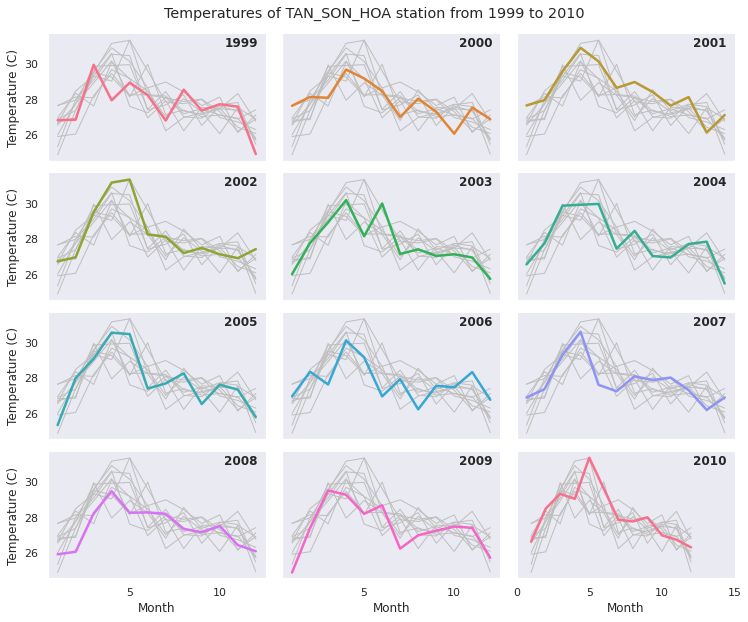

In [26]:
mult_line_plot_station("Vietnam", "TAN_SON_HOA", 1999, 2010)

Finally, we close the connection to our database as before.

In [27]:
conn.close()